# Import dependencies

In [19]:
from abc import ABC, abstractmethod

import random
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from dataclasses import dataclass

import torch
from torch import nn
from torch.distributions import Categorical
import torch.nn.functional as F

import scipy
import scipy.ndimage

from tqdm.notebook import tqdm
import easyrl.models.diag_gaussian_policy as DiagGaussian

In [2]:
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

# set random seed
seed = 0
set_random_seed(seed=seed)

# Set default parameters

In [3]:
def getDefaultParams():
    # here goes the default parameters for the agent
    config = dict(
        # env=env, the agent does not need to ahve access to the env because there is an engine
        learning_rate=0.00025,
        gamma=0.99,
        memory_size=200000,
        initial_epsilon=1.0,
        min_epsilon=0.1,
        max_epsilon_decay_steps=150000,
        warmup_steps=500,
        target_update_freq=2000,
        batch_size=32,
        device=None,
        disable_target_net=False,
        enable_double_q=False,
        use_gae=False,
        train_ac_iters=5,
        target_kl=0.01,
        clip_ratio=0.2,
        entropy_coef=0.01,
        use_critic=True
    )
    return config

# Create categorical policy network

In [4]:
# Stolen from easyrl Categorical policy policy with some modifications
class CategoricalPolicy(nn.Module):
    def __init__(self,
                 body_net,
                 action_dim,
                 in_features=None,
                 ):
        super().__init__()
        self.body = body_net
        if in_features is None:
            for i in reversed(range(len(self.body.fcs))):
                layer = self.body.fcs[i]
                if hasattr(layer, 'out_features'):
                    in_features = layer.out_features
                    break

        self.head = nn.Sequential(nn.Linear(in_features, action_dim), nn.Softmax())

    def forward(self, x=None, body_x=None, **kwargs):
        if x is None and body_x is None:
            raise ValueError('One of [x, body_x] should be provided!')
        if body_x is None:
            body_x = self.body(x, **kwargs)
        if isinstance(body_x, tuple):
            pi = self.head(body_x[0])
        else:
            pi = self.head(body_x)
        action_dist = Categorical(probs=pi)
        return action_dist, body_x

# Create backbone NN structure

In [5]:
def init_params(m):
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

class NNetwork(nn.Module):
    def __init__(self, input_dim, action_dim, final_activation=None, use_critic=False):
        self.final_activation = final_activation
        self.use_critic = use_critic
        super().__init__()
        #### A simple network that takes
        #### as input the history, and outputs the 
        #### distribution parameters.
        self.fcs = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU())
        self.out_layer = nn.Sequential(nn.Linear(64, action_dim))
        
        # Define critic's model
        if self.use_critic:
            self.critic = nn.Sequential(
                nn.Linear(input_dim, 128),
                nn.ReLU(),
                nn.Linear(128, 32),
                nn.Tanh(),
                nn.Linear(32, 1)
            )
        
        # Set initial weights and biases
        self.apply(init_params)

    def forward(self, ob):
        mid_logits = self.fcs(ob)
        logits = self.out_layer(mid_logits)
        if self.final_activation is not None:
            logits = self.final_activation(logits, dim=-1)
        if self.use_critic:
            return logits, self.critic(ob)
        else:
            return logits, None


# Define game parameters and NN initialization

In [6]:
RED_TEAM_ID = 1
BLUE_TEAM_ID = 0
NUM_PLAYERS = 5
RED_PLAYERS = 2
BLUE_PLAYERS = 3
HIST_SHAPE = 2 * 25 * (3 * NUM_PLAYERS + 5)
SELF_SHAPE = torch.tensor([5])
COMM_SHAPE = 32  # Change freely
WHO_SHAPE = torch.tensor([NUM_PLAYERS])
VOTE_SHAPE =torch.tensor([NUM_PLAYERS])

assert RED_PLAYERS + BLUE_PLAYERS == NUM_PLAYERS

def get_who():
    return NNetwork(SELF_SHAPE + HIST_SHAPE + NUM_PLAYERS*COMM_SHAPE, WHO_SHAPE, nn.functional.softmax, use_critic=False)

def get_comm(use_critic=False):
    return DiagGaussian.DiagGaussianPolicy(NNetwork(SELF_SHAPE + HIST_SHAPE + WHO_SHAPE, torch.tensor([64]), use_critic=use_critic), COMM_SHAPE, in_features=torch.tensor([64]))

def get_miss(mission_shapes = (10,10), use_critic=False):
    model = NNetwork(SELF_SHAPE + WHO_SHAPE + HIST_SHAPE, 64, use_critic=use_critic)
    return [CategoricalPolicy(model, mish, 64) for mish in mission_shapes]

def get_vote(use_critic=False):
    return CategoricalPolicy(NNetwork(HIST_SHAPE + SELF_SHAPE + WHO_SHAPE, 128, use_critic=use_critic), 2, 128)

def get_succ(use_critic=False):
    return CategoricalPolicy(NNetwork(HIST_SHAPE + SELF_SHAPE + WHO_SHAPE, 128,use_critic=use_critic), 2, 128)

@torch.no_grad()
def miss_players(miss):
    # 0: 0,1
    # 1: 0,2
    # 2: 0,3
    # 3: 0,4
    # 4: 1,2
    # 5: 1,3
    # 6: 1,4
    # 7: 2,3
    # 8: 2,4
    # 9: 3,4
    miss_cat = torch.zeros(NUM_PLAYERS)
    if miss<4:
        miss_cat[0] = 1
        miss_cat[miss+1] = 1
    elif miss<7:
        miss_cat[1] = 1
        miss_cat[miss-2] = 1
    elif miss<9:
        miss_cat[2] = 1
        miss_cat[miss-4] = 1
    else:
        miss_cat[3] = 1
        miss_cat[miss-5] = 1
    return miss_cat

# Agent class

In [7]:
@dataclass
class Agent(ABC):
    
    @abstractmethod
    def comm():
        pass

    @abstractmethod
    def who():
        pass

    @abstractmethod
    def miss():
        pass

    @abstractmethod
    def vote():
        pass

    @abstractmethod
    def succ():
        pass

class RedAgent():

    def __init__(self, lr, use_critic):
        self.lr = lr
        self.use_critic = use_critic

        self.COMM = get_comm(use_critic = use_critic)
#         self.who = (lambda *args : every)
        mission_models = get_miss(use_critic = use_critic)
        self.MISS = (lambda args : [mission_models[i](args) for i in range(2)])
        self.VOTE = get_vote(use_critic = use_critic)
        self.SUCC = get_succ(use_critic = use_critic)
        
        # Optimizers
        self.COMM_opt = torch.optim.Adam(self.COMM.parameters(), lr=lr)
        self.MISS_opt2 = torch.optim.Adam(mission_models[0].parameters(), lr=lr)
        self.MISS_opt3 = torch.optim.Adam(mission_models[1].parameters(), lr=lr)
        self.VOTE_opt = torch.optim.Adam(self.VOTE.parameters(), lr=lr)
        self.SUCC_opt = torch.optim.Adam(self.SUCC.parameters(), lr=lr)

class BlueAgent():
    
    def __init__(self, lr, use_critic):
        self.lr = lr
        self.use_critic = use_critic

        self.COMM = get_comm(use_critic=use_critic)
        self.WHO = get_who()
        mission_models = get_miss(use_critic=use_critic)
        self.MISS = (lambda args : [mission_models[i](args) for i in range(2)])
        self.VOTE = get_vote(use_critic=use_critic)
#         self.succ = (lambda *args : torch.distributions.bernoulli.Bernoulli(1))
        
        # Optimizers
        self.COMM_opt = torch.optim.Adam(self.COMM.parameters(), lr=lr)
        self.WHO_opt = torch.optim.Adam(self.WHO.parameters(), lr=lr)
        self.MISS_opt2 = torch.optim.Adam(mission_models[0].parameters(), lr=lr)
        self.MISS_opt3 = torch.optim.Adam(mission_models[1].parameters(), lr=lr)
        self.VOTE_opt = torch.optim.Adam(self.VOTE.parameters(), lr=lr)
    
    

In [58]:
# Baseline agents
class ConstantDistribution():
#   A "distribution" that always returns the same result when sampled

    def __init__(self, values):
#       Values must support element-wise comparison with ==
        self.values = values
    
    def sample(self):
        return self.values
    
    def log_prob(self, actions):
        return self.values == actions

class RedAgentBaseline():
    # this red agent takes actions according to the following rules:
    # COMM - outputs a random vector
    # MISS - always randomly choose 1 red player and 1~2 blue players (according to how many players go on mission)
    # VOTE - always vote yes if there are one or more red players on the mission, else no
    # SUCC - always fail the mission

    def __init__(self, lr = 0.01):
        self.COMM = (lambda args: (ConstantDistribution(torch.rand((COMM_SHAPE))), None))
        
        # Optimizers
        self.COMM_opt = None
        self.MISS_opt2 = None
        self.MISS_opt3 = None
        self.VOTE_opt = None
        self.SUCC_opt = None

    def SUCC(self, obs):
        return Categorical(probs=torch.Tensor([1])), None
    
    def VOTE(self, obs):
        # obs = SELF_SHAPE + EVERY_SHAPE + (HIST_SHAPE) <- who goes on mission is here
        # env.hist = torch.zeros((2, 25, 20))
        every = obs[SELF_SHAPE:SELF_SHAPE+WHO_SHAPE]
        hist = obs[SELF_SHAPE+WHO_SHAPE:]
        hist = hist.reshape((2, 25, len(hist) // 50))
        # find the LAST VALID mission combination
        # -- hist[1, si, 5:10]
        miss = hist[0, hist[1, :, 5].sum().long()-1, 5:10]
        probs = torch.Tensor([0, 1]) if (miss == RED_TEAM_ID).sum() > 0 else torch.Tensor([1, 0])
        return Categorical(probs=probs), None

    def MISS(self, obs):
        # obs = SELF_SHAPE + EVERY_SHAPE + HIST_SHAPE
        every = obs[SELF_SHAPE:SELF_SHAPE+WHO_SHAPE]
        # miss 2
        misses = []
        for num_pl_miss in [2, 3]:
            seq = np.arange(math.comb(NUM_PLAYERS, num_pl_miss))
            np.random.shuffle(seq)
            for comb in seq:
                miss = miss_players(comb) if num_pl_miss == 2 else 1 - miss_players(comb)
                if (every[miss.numpy().astype(bool)] == RED_TEAM_ID).sum() == 1:
                    break
            assert (every[miss.numpy().astype(bool)] == RED_TEAM_ID).sum() == 1
            misses.append(torch.clone(miss).long())
        return (ConstantDistribution(torch.Tensor(miss[0])), None), (ConstantDistribution(torch.Tensor(miss[1])), None)

class BlueAgentBaseline():
    # this blue agent takes actions according to the following rules:
    # COMM - outputs a random vector
    # MISS - always choose itself and 1~2 other players (according to how many players go on mission)
    # VOTE - always vote yes if itself is chosen, else no
    # (For WHO, we can assign a BADNESS factor to every other agent according to the number of failures of the missions that the other agents deployed)

    def __init__(self, lr = 0.01):
        self.COMM = lambda args: (ConstantDistribution(torch.rand((COMM_SHAPE))), None)
        
        self.COMM_opt = None
        self.WHO_opt = None
        self.MISS_opt2 = None
        self.MISS_opt3 = None
        self.VOTE_opt = None
    
    def VOTE(self, obs):
        # obs = SELF_SHAPE + WHO_SHAPE + (HIST_SHAPE) <- who goes on mission is here
        # env.hist = torch.zeros((2, 25, 20))
        self_v = obs[:SELF_SHAPE]
        hist = obs[SELF_SHAPE+WHO_SHAPE:]
        hist = hist.reshape((2, 25, len(hist) // 50))
        # find the LAST VALID mission combination
        # -- hist[1, si, 5:10]
        miss = hist[0, hist[1, :, 5].sum().long()-1, 5:10]
        # 1 if cond else 0
        probs = torch.Tensor([0, 1]) if (miss * self_v).sum() == 0 else torch.Tensor([1, 0])
        return Categorical(probs=probs), None

    def MISS(self, obs):
        # obs = SELF_SHAPE + WHO_SHAPE + HIST_SHAPE
        self_v = obs[:SELF_SHAPE]
        # miss 2
        misses = []
        for num_pl_miss in [2, 3]:
            seq = np.arange(math.comb(NUM_PLAYERS, num_pl_miss))
            np.random.shuffle(seq)
            for comb in seq:
                miss = miss_players(comb) if num_pl_miss == 2 else 1 - miss_players(comb)
                if (self_v * miss).sum() == 1:
                    break
            assert (self_v * miss).sum() == 1
            misses.append(torch.clone(miss))
        return (ConstantDistribution(torch.Tensor(miss[0]).long()), None), (ConstantDistribution(torch.Tensor(miss[1]).long()), None)
    
    def WHO(self, obs):
#         obs = obs.numpy()
        self_v = obs[0:SELF_SHAPE]
        _comm_v = obs[SELF_SHAPE:COMM_SHAPE*NUM_PLAYERS]
        hist = obs[SELF_SHAPE+COMM_SHAPE*NUM_PLAYERS:]
        hist = hist.reshape((2, 25, len(hist) // 50))
        
        # Create badness score
        previous_mission_players = hist[1, :, 5:10]
#         previous_mission_successes = np.argmax(hist[1, :, 15:18], axis=-1)
        # 0 -> no mission
        # 1 -> success
        # 2 -> failure
        mission_no_result = hist[1, :, 15] == 1
        mission_failures = hist[1, :, 17] == 1
        
        # Number of missions each player was on minus the missions with no result
        total_previous_mission_players = torch.sum(previous_mission_players, dim=0) - torch.sum(previous_mission_players * mission_no_result.reshape(25,1), dim=0)
        # Number of mission each player was on that failed
        previous_mission_failures_players = torch.sum(previous_mission_players * mission_failures.reshape(25,1), dim=0)
        
        # Badness = Number_of_failed_missions_you_were_on / number_of_missions_you_were_on
        badness_score = previous_mission_failures_players / total_previous_mission_players
        # In the case where someone has never been on a mission, this will result in a nan
        # We will fill nans with 0.5.
        badness_score = torch.nan_to_num(badness_score, nan=0.5)
        
        # We know that I am blue
        badness_score[np.argmax(self_v)] = 0
        
        return badness_score, None
        

        
        

# Game environment definition

In [59]:
class AvalonEnv():
    def __init__(self):
        super().__init__()
        self.nm = [2, 3, 2, 3, 3, 0]
        self.reset()
    
    def reset(self):
        self.mi = 0
        self.ri = 0
        self.si = 0
        self.li = 0
        self.hist = torch.zeros((2, 25, 20))
        every = [0, 0, 0, 1, 1]
        random.shuffle(every)
        self.every = torch.Tensor(every.copy())        
        self.who = torch.normal(0.5, 0.1, (NUM_PLAYERS, NUM_PLAYERS))
        self.done = False
        self.winning_team = None
        
        # the initial observation of "hist" is all zeros
        # EXCEPT a one at the leader id (self.li) location of the zero-th step
        self.hist[0, 0, self.li] = 1
        self.hist[1, 0, :5] = 1
        
        return self.get_observation()
    
    def get_observation(self):         
        return self.hist, self.every, self.who, self.li, self.si, self.mi, self.nm[self.mi], self.done
    
    def update_who(self, who_m):
        self.who = who_m
        
    def update_miss(self, miss):
        # save to self.hist
        self.hist[0, self.si, 5:10] = miss.detach()
        self.hist[1, self.si, 5:10] = 1
        return self.hist
    
    def update_vote(self, vote):
        # save to self.hist
        self.hist[0, self.si, 10:15] = vote
        self.hist[1, self.si, 10:15] = 1
        
        # check if there are more yeses than noes
        if (vote >= 0.5).sum() > 2:
            # set relevance of only the no mission flag
            self.hist[1, self.si, 15] = 1
        else:
            # set the no mission flag
            self.hist[0, self.si, 15] = 1

            # set the current round
            self.hist[0, self.si, 19] = self.ri
            
            # set the number of failures
            self.hist[0, self.si, 18] = self.hist[0, self.si-1, 18] if self.si else 0
            
            # set relevance
            self.hist[1, self.si, 15:] = 1
            
            if self.ri == 4:
                # game is over, red team wins
                self.winning_team = RED_TEAM_ID
                self.done = True
                
            # update leader
            self.li = (self.li + 1) % 5
            self.hist[0, self.si, self.li] = 1
            self.hist[1, self.si, :5] = 1
            
            # update round id
            self.ri = (self.ri+1) % 5
            
            # update step id
            self.si += 1
        return self.hist
        
    def update_succ(self, succ):
        # set the current round
        self.hist[0, self.si, 19] = self.ri
        
        # set relevance
        self.hist[1, self.si, 16:] = 1
        
        if (succ < 0.5).sum():
            # set the mission failure flag
            self.hist[0, self.si, 17] = 1
            
            # set the number of failures
            self.hist[0, self.si, 18] = self.hist[0, self.si-1, 18] + 1 if self.si else 1
        else:
            # set the mission success flag
            self.hist[0, self.si, 16] = 1
            
            # set the number of failures
            self.hist[0, self.si, 18] = self.hist[0, self.si-1, 18] if self.si else 0
        
        # check if game is over
        if self.hist[0, self.si, 18]  == 3:
            # game is over, red team wins
            self.winning_team = RED_TEAM_ID
            self.done = True
        elif self.mi == 2 + self.hist[0, self.si, 18]:
            # game is over, blue team wins
            self.winning_team = BLUE_TEAM_ID
            self.done = True
            
        # update mission id
        self.mi += 1

        # update round id
        self.ri = 0

        # update step id
        self.si += 1

        # update leader
        self.li = (self.li + 1) % 5
        self.hist[0, self.si, self.li] = 1
        self.hist[1, self.si, :5] = 1

# Game engine and runner

In [83]:
args = getDefaultParams()
@dataclass
class AvalonEngine:
    env: AvalonEnv
    train_episodes: int
    max_epoch: int
    blue: BlueAgent
    red: RedAgent
    trainable_models: list
    gamma: float
    gae_lambda: float
    
    def run(self, is_training=True):
        # Useful for constructing the self vector (self_v)
        self_m = torch.eye(5)
        history_log = []
        winning_log = []
        every_log = []
        
        for epoch in tqdm(range(self.max_epoch), desc='epoch', leave=False):
            for train_model in tqdm(self.trainable_models, desc='train_model'):
                # print(f'train model = {train_model}')

                winning_team = []
                every_replay = []
                # trajectory buffer
                if is_training:
                    obs_replay_epoch = []
                    actions_replay_epoch = []
                    log_probs_epoch = []
                    stepid_replay_epoch = []
                    

                for episode in range(self.train_episodes):
                    hist, every, who, li, si, mi, nm, done = self.env.reset()
                    
                    every_replay.append(every)
                    if is_training:
                        obs_replay = []
                        actions_replay = []
                        log_probs = []
                        stepid_replay = []
                        

                    while not done:
                        # print(f'li, si, mi, ri = {li}, {si}, {mi}, {self.env.ri}')
                        # Flow: communication -> predict who -> decide miss -> voting -> succ/fail -> next round
                        #                                                             -> next round

#                         print(f'Mission {mi} Round {self.env.ri} Step {si}')
                        
                        ''' Communication '''
                        # Initialize communication matrix
                        comm_m = []
                        # Loop over every agent
                        for i in range(5):
                            # create input vector for network                            
                            comm_in = torch.cat((self_m[i], every if every[i] else who[i], hist.flatten()))
                            
#                             if agents == []:
#                                 comm_v = torch.rand(COMM_SHAPE)
#                             else:
                            
                            # Call the COMM network of the current agent and return the communication vector (comm_v)
                            comm_dist, _ = self.blue.COMM(comm_in) if every[i]==BLUE_TEAM_ID else self.red.COMM(comm_in)
                            comm_v = comm_dist.sample()
                
                            # Append it to the communication matrix (comm)
                            comm_m.append(comm_v)
                            # If we are currently training on the COMM network, save it to experience buffer
                            if is_training and ((train_model == 'comm_red' and every[i] == RED_TEAM_ID) or \
                                    (train_model == 'comm_blue' and every[i] == BLUE_TEAM_ID)):
                                obs_replay.append(comm_in)
                                actions_replay.append(comm_v)
                                log_probs.append(comm_dist.log_prob(comm_v))
                                stepid_replay.append(si)
                        # Make the torch.Tensor communication matrix
                        comm_m = torch.cat(comm_m)
                        
#                         print(f'  All the players communicated')

                        ''' Predicting Who '''
                        # Loop over every agent
                        for i in range(NUM_PLAYERS):
                            # continue if the agent is on the red team
                            if every[i] == RED_TEAM_ID:
                                continue
                            # create input vector for network
                            who_in = torch.cat((self_m[i], comm_m, hist.flatten()))

                            # Call the WHO network of the current agent (on the blue team)
                            # and return the who vector (who)
                            who_v, _ = self.blue.WHO(who_in)
                            
                            # Update "who_v" into "who"
                            who[i] = who_v
                            # If we are currently training on the WHO network, save it to experience buffer
                            if is_training and train_model == 'who_blue':
                                obs_replay.append(who_in)
                                actions_replay.append(who_v)
                                stepid_replay.append(si)
                        # update the who matrix to the environment
                        self.env.update_who(who)
                        
#                         print(f'  All blue players predicted who')
#                         for i in range(NUM_PLAYERS):
#                             if every[i] == RED_TEAM_ID:
#                                 continue
#                             print(f'    {i} -> {who[i]}')

                        ''' Deciding candidates to go on mission '''
                        # create input vector for "miss" network
                        miss_in = torch.cat((self_m[li], every if every[li] else who[li], hist.flatten()))

                        # Only call the leader
                        miss_dist = self.blue.MISS(miss_in) if every[li]==BLUE_TEAM_ID else self.red.MISS(miss_in)
                        miss = miss_dist[nm - 2][0].sample()
            
                        # If we are currently training on the MISS network, save it to the experience buffer
                        if is_training and (('miss_red' in train_model and every[i] == RED_TEAM_ID) or ('miss_blue' in train_model and every[i] == BLUE_TEAM_ID)):
                            if str(nm) in train_model:
                                obs_replay.append(miss_in)
                                actions_replay.append(miss)
                                log_probs.append(miss_dist)
                                stepid_replay.append(si)
                        # Update the "miss" vector to the environment
                        miss = miss_players(miss.long()) if nm==2 else 1-miss_players(miss.long())
                        hist = self.env.update_miss(miss)
                        
#                         print(f'  Leader {li} decides {miss} go on mission')
                            
                        ''' Voting YES/NO for the mission candidates '''
                        # Initialize vote vector
                        vote = []
                        # Loop over every agent
                        for i in range(5):
                            # create input vector for network
                            vote_in = torch.cat((self_m[i], every if every[i] else who[i], hist.flatten()))

                            # Call the VOTE network of the current agent and return vote_pi
                            vote_dist, _ = self.blue.VOTE(vote_in) if every[i]==BLUE_TEAM_ID else self.red.VOTE(vote_in)
                            vote_pi = vote_dist.sample()
            
                            # Append the voting results to "vote"
                            vote.append(vote_pi)
                            # If we are currently training on the VOTE network, save it to experience buffer
                            if is_training and ((train_model == 'vote_red' and every[i] == RED_TEAM_ID) or \
                                    (train_model == 'vote_blue' and every[i] == BLUE_TEAM_ID)):
                                obs_replay.append(vote_in)
                                actions_replay.append(vote_pi)
                                log_probs.append(vote_dist)
                                stepid_replay.append(si)
                        # Make the torch.Tensor vote vector
                        vote = torch.Tensor(vote)
                        
                        # Update the "vote" vector to the environment
                        hist = self.env.update_vote(vote)
                        
#                         print(f'  Voting results {vote} -> {(vote >= 0.5).sum() > 2}')
                        
    
                        ''' Success/Failure for the mission '''
                        # check if there are more yeses than noes
                        if (vote >= 0.5).sum() > 2:
                            # Initialize succ vector
                            succ = []
                            # Loop over every agent   
                            for i in range(5):
                                if not miss[i]:
                                    continue
                                # create input vector for network
                                succ_in = torch.cat((self_m[i], every if every[i] else who[i], hist.flatten()))

                                # Call the SUCCESS network of the current agent and return succ_i
                                if every[i] == BLUE_TEAM_ID:
                                    succ_i = torch.Tensor([1.0])
                                else:
                                    succ_dist, _ = self.red.SUCC(succ_in)
                                    succ_i = succ_dist.sample()
            
                                # Append the voting results to "vote"
                                succ.append(succ_i)
                                
                                # If we are currently training on the SUCCESS network, save it to experience buffer
                                if is_training and train_model == 'succ_red' and every[i] == RED_TEAM_ID:
                                    obs_replay.append(succ_in)
                                    actions_replay.append(succ_i)
                                    log_probs.append(succ_dist)
                                    stepid_replay.append(si)
                            
                            # Make the torch.Tensor succ vector
                            succ = torch.Tensor(succ)

                            # Update the "succ" vector to the environment
                            self.env.update_succ(succ)
                            
#                         print(f'  Mission: {hist[0,self.env.si-1,15:18]} - {hist[0,self.env.si-1,18]} Fails {hist[0,self.env.si-1,19]} Round')
                        
                        hist, every, who, li, si, mi, nm, done = self.env.get_observation()
                        
                    # append the result of each episode into the epoch buffer
                    winning_team.append(self.env.winning_team)
                    history_log.append(hist)
                    if is_training:
                        obs_replay_epoch.append(obs_replay)
                        actions_replay_epoch.append(actions_replay)
                        log_probs_epoch.append(log_probs)
                        stepid_replay_epoch.append(stepid_replay)
                        last_step = si
                
                if is_training:
                    obs_all = []
                    actions_all = []
                    log_probs_all = []
                    stepid_all = []
                    discounted_rewards = []
                    for epi in range(self.train_episodes):
                        if len(stepid_replay_epoch[epi]) > 0:
                            obs_all += obs_replay_epoch[epi]
                            actions_all += actions_replay_epoch[epi]
                            log_probs_all += log_probs_epoch[epi]
                            stepid_all += stepid_replay_epoch[epi]
                            discounted_rewards += compute_discounted_rewards(stepid_replay_epoch[epi], last_step, winning_team[epi], train_model, self.gamma)   
                    value_function = (lambda x : 0)
                    sb = preprocess(obs_all, actions_all, stepid_all, discounted_rewards, value_function)

                    model_lookup = {"comm_red": (red.COMM, red.COMM_opt),
                        "miss_red_2" : (red.MISS, red.MISS_opt2),
                        "miss_red_3" : (red.MISS, red.MISS_opt3),
                        "vote_red" : (red.VOTE, red.VOTE_opt), 
                        "succ_red" : (red.SUCC, red.SUCC_opt),
                        "who_blue" : (blue.WHO, blue.WHO_opt),
                        "comm_blue" : (blue.COMM, blue.COMM_opt),
                        "miss_blue_2" : (blue.MISS, blue.MISS_opt2),
                        "miss_blue_3" : (blue.MISS, blue.MISS_opt3),
                        "vote_blue" : (blue.VOTE, blue.VOTE_opt)}

                    acmodel, optimizer = model_lookup[train_model]

                    if train_model != "who_blue":
                        update_parameters_ppo(optimizer, acmodel, sb, args, train_model)
                    else:
                        optimizer.zero_grad()
                        loss = 0
                        for epi in range(self.train_episodes):
                            loss += ((acmodel(obs_all[epi])[0] - every_replay[epi]) ** 2).sum()
                        loss.backward()
                        optimizer.step()

                # end of self.train_episodes episodes
                # # obs_replay, actions_replay, stepid_replay, winning_team
                # if len(stepid_replay) > 0:
                #     discounted_rewards = compute_discounted_rewards(stepid_replay, winning_team, train_model, self.gamma)
                #     advantage_gae = compute_advantage_gae([0.0] * len(stepid_replay), discounted_rewards, stepid_replay, self.gae_lambda, self.gamma, train_model)
                # sb['obs', 'action', 'advantage_gae' or 'advantage', 'discounted_reward']
                
                # end of epoch
                winning_log.extend(winning_team)
                every_log.extend(every_replay)
            
            if epoch % 50 == 0:
                evaluate(history_log, winning_log, every_log)
        
        return history_log, winning_log, every_log
                    

# PPO algorithm

In [84]:
# args = getDefaultParams()
def compute_discounted_rewards(stepid_replay, last_step, winning_team, train_model, gamma):

    # last_step = 10
    # stepid_replay = [0, 0, 1, 3, 5, 5, 6, 6, 6, 8]

    # Calculate the discounted rewards
    win_team_color = 'red' if winning_team == RED_TEAM_ID else 'blue'
    R = 1 if win_team_color in train_model else -1
    discounted_rewards = [R * (gamma ** (last_step - 1 - stepid_replay[-1]))]
    curr_step = stepid_replay[-1]

    for si in range(len(stepid_replay) - 2, -1, -1):
        discounted_rewards += [discounted_rewards[-1] * (gamma ** (curr_step - stepid_replay[si]))]
        curr_step = stepid_replay[si]

    # stepN = len(stepid_replay)
    # win_team_color = 'red' if winning_team[-1] == RED_TEAM_ID else 'blue'
    # discounted_rewards = [1 if win_team_color in train_model else -1]

    # for i in range(stepN - 2, -1, -1):
    #     if stepid_replay[i] == stepid_replay[i+1]:
    #         # the current step of the i-th index is the same as the step of the i+1-th index
    #         discounted_rewards.append(discounted_rewards[-1])
    #     elif stepid_replay[i] != 0 and stepid_replay[i+1] == 0:
    #         # the current step of the i-th index is the last step of a new episode
    #         win_team_color = 'red' if winning_team[i] == RED_TEAM_ID else 'blue'
    #         discounted_rewards.append(1 if win_team_color in train_model else -1)
    #     else:
    #         # the current step of the i-th index is the step of the i+1-th index minus 1
    #         discounted_rewards.append(discounted_rewards[-1] * gamma)

    discounted_rewards.reverse()
    return discounted_rewards


def preprocess(obs_replay, actions_replay, stepid_replay, discounted_rewards, value_function):
    # Example:
    # preprocess(*full_replay_buffer, range(10), (lambda x: 0))

    # print(len(obs_replay))
    # print(len(stepid_replay))

    assert len(obs_replay) == len(actions_replay)
    assert len(obs_replay) == len(stepid_replay)
    assert len(discounted_rewards) == len(obs_replay)
    discounted_rewards = torch.Tensor(discounted_rewards)
    # print(obs_replay)
    obs_replay = torch.stack(obs_replay)
    actions_replay = torch.stack(actions_replay)
    # obs_replay = torch.Tensor(obs_replay)
    sb = {
        "obs" : obs_replay,
        "action" : actions_replay,
        "advantage" : discounted_rewards - value_function(obs_replay),
        "discounted_reward" : discounted_rewards,
    }
    return sb



def update_parameters_ppo(optimizer, acmodel, sb, args, train_model):
    def _compute_policy_loss_ppo(logp, old_logp, entropy, advantages):
        policy_loss, approx_kl = 0, 0

        ### TODO: implement PPO policy loss computation (30 pts).  #######
        logr = logp - old_logp
        ratios = torch.exp(logr)
        
        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1-args['clip_ratio'], 1+args['clip_ratio']) * advantages
        
        policy_loss = (-torch.min(surr1, surr2) -args['entropy_coef']*entropy).mean()
        
        # approx_kl = torch.sum(torch.exp(logp) * logr)
        #approx_kl = torch.nn.functional.kl_div(logp, old_logp)

        # approx_kl = ((logr.exp() - 1) - logr).sum()
        approx_kl = ((logr ** 2) / 2).sum()
        
        ##################################################################
        
        return policy_loss, approx_kl
    
    def _compute_value_loss(values, returns):
        ### TODO: implement PPO value loss computation (10 pts) ##########
        value_loss = F.mse_loss(values.squeeze(-1), returns).mean() #(values - returns).pow(2).mean()
        ##################################################################

        return value_loss

    result = acmodel(sb['obs'])
    if 'miss' in train_model:
        if "2" in train_model:
            result = result[0]
        else:
            result = result[1]

    dist, (_, values) = result
    
    old_logp = dist.log_prob(sb['action']).detach()
    logp = dist.log_prob(sb['action'])
    dist_entropy = dist.entropy()
    
    advantage = sb['advantage_gae'] if args['use_gae'] else sb['advantage']
    
    policy_loss, _ = _compute_policy_loss_ppo(logp, old_logp, dist_entropy, advantage)

    if not args["use_critic"]:
        values = torch.zeros_like(sb['discounted_reward'])

    value_loss = _compute_value_loss(values, sb['discounted_reward'])

    for i in range(args['train_ac_iters']):
        result = acmodel(sb['obs'])
        if 'miss' in train_model:
            if "2" in train_model:
                result = result[0]
            else:
                result = result[1]
        dists, (_, values) = result
            
        logp = dists.log_prob(sb['action'])
        dist_entropy = dists.entropy()
        
        optimizer.zero_grad()
        
        loss_pi, approx_kl = _compute_policy_loss_ppo(logp, old_logp, dist_entropy, advantage)

        if not args["use_critic"]:
            values = torch.zeros_like(sb['discounted_reward'])
            
        loss_v = _compute_value_loss(values, sb['discounted_reward'])

        loss = loss_v + loss_pi
        if approx_kl > 1.5 * args['target_kl']:
            break
        
        loss.backward(retain_graph=True)
        optimizer.step()
    
    update_policy_loss = policy_loss.item()
    update_value_loss = value_loss.item()

    logs = {
        "policy_loss": update_policy_loss,
        "value_loss": update_value_loss,
    }

    return logs

In [85]:
def evaluate(hist_log, winning_log, every_log):
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w
    plt.plot(winning_log)
    plt.title("Success Rate over time")
    plt.show()
    plt.plot(moving_average(winning_log, 50))
    plt.show()

# Run it

epoch:   0%|          | 0/4000 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/eliotcowan/Documents/Classes/6.484/venv/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


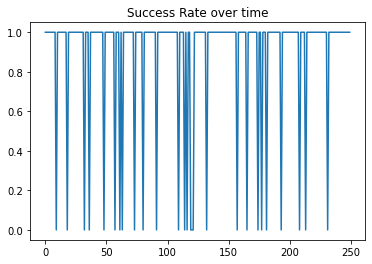

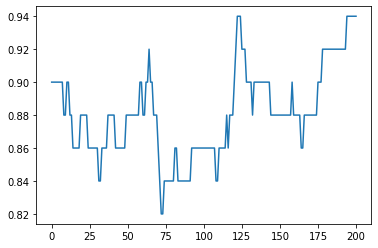

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/eliotcowan/Documents/Classes/6.484/venv/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

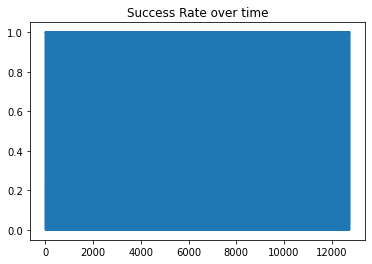

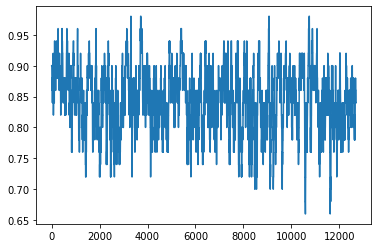

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/eliotcowan/Documents/Classes/6.484/venv/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

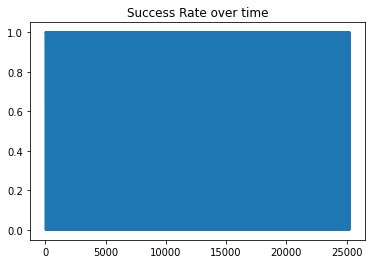

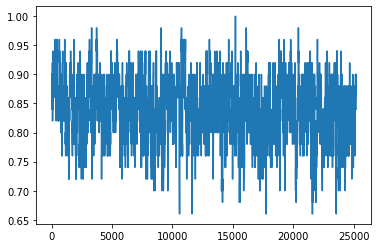

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/eliotcowan/Documents/Classes/6.484/venv/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

train_model:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# trainable_models=['comm_red', 'comm_blue', 'who_blue', 'miss_red_2', 'miss_red_3', 'miss_blue_2', 'miss_blue_3', 'vote_red', 'vote_blue', 'succ_red']
# trainable_models=['comm_red', 'miss_red_2', 'miss_red_3', 'vote_red', 'succ_red']
trainable_models=['comm_blue', 'who_blue', 'miss_blue_2', 'miss_blue_3', 'vote_blue',]


set_random_seed(1)

lr = 0.00025
gamma = 0.99
gae_lambda = 0.95
# blue = BlueAgent(lr=lr, use_critic=args["use_critic"]) #BlueAgent(lr=lr, use_critic=args["use_critic"]) #BlueAgentBaseline()
# red = RedAgentBaseline()#RedAgent(lr=lr, use_critic=args["use_critic"]) #RedAgentBaseline(

my_env = AvalonEnv()
engine = AvalonEngine(env=my_env, blue=blue, red=red, train_episodes=50, max_epoch=4000,
                      trainable_models=trainable_models, gamma=gamma, gae_lambda=gae_lambda)
hist_log, winning_log, every_log = engine.run()
evaluate(hist_log, winning_log, every_log)

In [73]:
def evaluate(hist_log, winning_log, every_log):
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w
    plt.plot(winning_log)
    plt.title("Success Rate over time")
    plt.show()
    plt.plot(moving_average(winning_log, 50))
    plt.show()

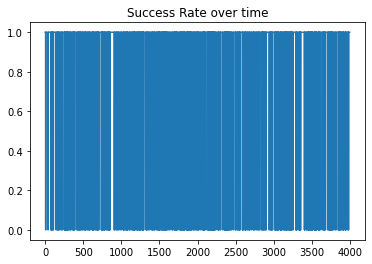

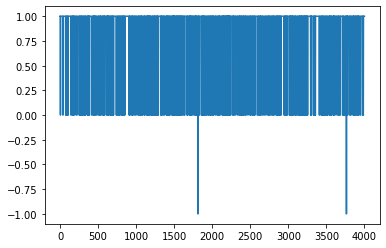

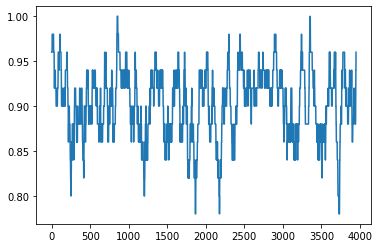

In [72]:
%matplotlib inline
evaluate(hist_log, winning_log, every_log)

In [ ]:
# #@title
# def compute_advantage_gae(values, discounted_rewards, stepid_replay, gae_lambda, gamma, train_model):
#     rewards = [x if abs(x) == 1 else 0 for x in discounted_rewards]
#     # print(rewards)
#     # print(discounted_rewards)

#     reps = 0
#     if stepid_replay[0] != 0:
#         print(train_model)
#         print(stepid_replay)
#     while stepid_replay[reps] == 0:
#         reps += 1

#     rewards_single = torch.Tensor(rewards[::reps])
#     values_single = torch.Tensor(values[::reps])

#     end_of_epi = np.arange(len(rewards_single))[rewards_single != 0].astype(int)
    
#     # print(end_of_epi)
#     # print(values_single)

#     last_end = -1
#     total_advs = []
#     for end in end_of_epi:
#         # calculate advantage_gae from index last_end+1 ~ end\
#         theta = rewards_single[last_end+1:end+1] - values_single[last_end+1:end+1]
#         theta[:-1] += gamma * values_single[last_end+2:end+1]
#         gl = gamma * gae_lambda
#         advantages = torch.tensor([
#             (theta[i:] * (gl ** torch.arange(end - last_end -i))).sum() for i in range(end - last_end)
#         ])

#         # print(f'last_end: {last_end} ~ end: {end} => {len(advantages)}')
#         # print(advantages)
#         total_advs.append(advantages)
#         last_end = end
#     ############################################################################
    
#     total_advs = torch.concat(total_advs)
#     torch.repeat_interleave(total_advs, 2)

#     # print(total_advs)
#     # print(torch.repeat_interleave(total_advs, 2))
#     # assert 0

#     return total_advs